# Mars Terrain Semantic Segmentation: Final Model

## Name your model

In [1]:
# Model name
model_name = 'Final_Model'

In [2]:
from datetime import datetime

# Generate timestamp
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")

# Unified filename for both the final model and checkpoint
model_filename = f"model_{model_name}_{timestamp}.keras"

## Connect Colab to Google Drive

In [3]:
COLAB = True

if COLAB:
    print("COLAB")
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/ANN_Fibo+Fra+Trama+Auro
else:
    print("NO COLAB")

COLAB
Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1TpLPrhIOAQO4RROYzsy9L9wP58AkN0VD/ANN_Fibo+Fra+Trama+Auro


## Import Libraries

In [4]:
# General imports
import os
import random
from datetime import datetime

# Numerical and data manipulation
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mixed precision setup
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Sklearn for train-test splitting
from sklearn.model_selection import train_test_split

# OpenCV for image processing
import cv2

# tqdm for progress visualization
from tqdm import tqdm

# Matplotlib for visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
%matplotlib inline

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print environment details
print()
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")


TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## Load Data

In [28]:
# --------------- #
# Load the dataset
# --------------- #

data_name = 'clean_dataset.npz'
file_path = f"data/{data_name}"
data = np.load(file_path)


training_set = data["training_set"]
X_train = np.stack(training_set[:, 0], axis=0)  # Images
y_train = np.stack(training_set[:, 1], axis=0)  # Masks

X_test = data["test_set"]  # Test Images

# Preprocess images and masks
if X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]
if X_test.ndim == 3:
    X_test = X_test[..., np.newaxis]

X_train = X_train / 255.0
X_test = X_test / 255.0

if y_train.ndim == 3:
    y_train = y_train[..., np.newaxis]

original_count = X_train.shape[0]
print(f"Number of images the {data_name} dataset: {original_count}")

# Define label mapping
label_mapping = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

category_map = {key: key for key in label_mapping.keys()}

Number of images the clean_dataset.npz dataset: 2431


In [29]:
# Split data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Print shapes of the datasets
print("Shape of X_train_final:", X_train_final.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train_final:", y_train_final.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train_final: (1944, 64, 128, 1)
Shape of X_val: (487, 64, 128, 1)
Shape of y_train_final: (1944, 64, 128, 1)
Shape of y_val: (487, 64, 128, 1)


## Augmentations

Augmenting data:   0%|          | 0/1944 [00:00<?, ?it/s]

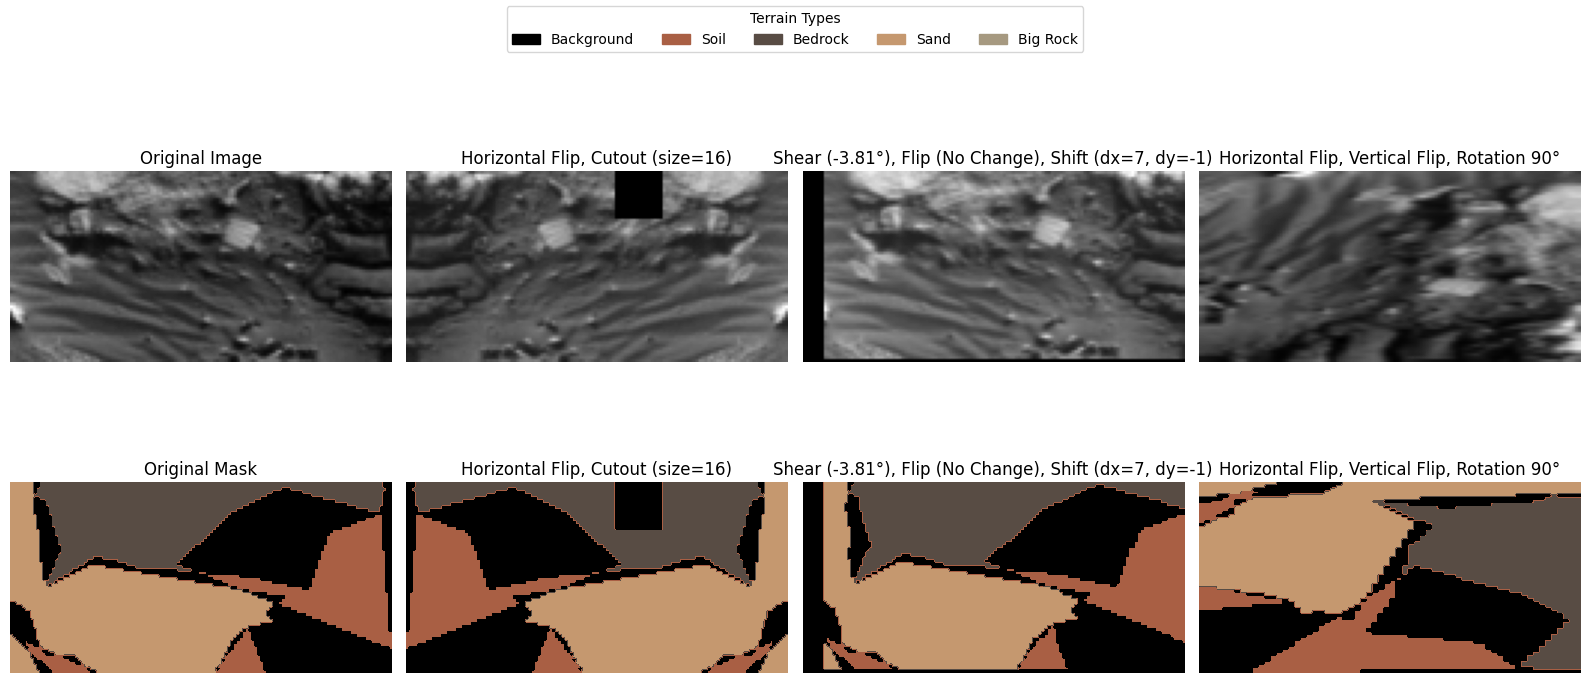

Augmenting data: 100%|██████████| 1944/1944 [00:02<00:00, 829.38it/s] 


In [ ]:
from AugmentationsUtils import *

# Augment the training set and plot images for the specified index
augmented_X_train, augmented_y_train = apply_augmentations(
    X_train_final,
    y_train_final,
    num_augmented= 3,  # Number of augmented versions per original image
    plot_index= 0  # Index of the image to plot
)

##  Model

In [37]:
from models.final_dual_branch import *

# Instantiate the model
input_shape = augmented_X_train.shape[1:]  # Use the shape of the input images
num_classes = 5  # As per dataset details
model = get_model(input_shape=input_shape, num_classes=num_classes, dropout_rate=0)

### Custom functions and metrics definition

In [38]:
# -------------------------------------- #
#                  Metric                #
# -------------------------------------- #

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        mask = tf.reduce_all([tf.not_equal(y_true, label) for label in self.labels_to_exclude], axis=0)
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# -------------------------------------- #
#              Loss Functions            #
# -------------------------------------- #


def mean_iou_loss(num_classes, labels_to_exclude=None, epsilon=1e-6):
    """
    Mean IoU Loss Function.

    Args:
        num_classes: Number of classes in the segmentation task.
        labels_to_exclude: List of labels to exclude when calculating IoU.
    Returns:
        A function that calculates the Mean IoU loss.
    """
    def loss(y_true, y_pred):
        # Convert predictions to class probabilities
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Convert true labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(tf.squeeze(y_true, axis=-1), tf.int32), num_classes)

        # Flatten the tensors
        y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
        y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        union = tf.reduce_sum(y_true_flat + y_pred_flat, axis=0) - intersection

        # Mask out excluded labels
        if labels_to_exclude is not None:
            for label in labels_to_exclude:
                intersection = tf.tensor_scatter_nd_update(
                    intersection,
                    [[label]],
                    [0.0]
                )
                union = tf.tensor_scatter_nd_update(
                    union,
                    [[label]],
                    [0.0]
                )

        # Compute IoU for each class and average over classes
        iou = (intersection + epsilon) / (union + epsilon)
        mean_iou = tf.reduce_mean(iou)

        # Invert to use as loss (lower IoU means higher loss)
        return 1.0 - mean_iou

    return loss


def focal_loss_ignore_class_0(alpha=0.25, gamma=2.0, num_classes=None):
    """
    Focal Loss Function that ignores class 0, with fixed alpha for all other classes.

    Args:
        alpha: Weighting factor for positive classes to address class imbalance.
        gamma: Focusing parameter to down-weight easy examples.
        num_classes: Number of classes in the segmentation task.
    Returns:
        A function that calculates the Focal Loss, ignoring class 0.
    """
    def loss(y_true, y_pred):
        # Convert predictions to class probabilities (softmax output)
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Convert true labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(tf.squeeze(y_true, axis=-1), tf.int32), num_classes)

        # Ignore class 0 in the loss calculation
        y_true_no_bg = y_true_one_hot[..., 1:]  # Remove the first class (class 0)
        y_pred_no_bg = y_pred[..., 1:]         # Remove the first class (class 0)

        # Compute the focal loss
        cross_entropy = -y_true_no_bg * tf.math.log(y_pred_no_bg + 1e-8)  # Cross entropy with stability

        # Apply a fixed alpha for all classes and calculate the focal loss
        weight = alpha * tf.math.pow(1 - y_pred_no_bg, gamma)  # Focusing weight
        focal_loss = weight * cross_entropy

        # Average over all pixels and classes (across the batch and spatial dimensions)
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

# -------------------------------------- #
#                   Tools                #
# -------------------------------------- #

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)

    # Create the lookup table
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )

    # Ensure the label is a Tensor
    label = tf.convert_to_tensor(label, dtype=tf.int32)

    return table.lookup(label)


def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        """
        Initialize the visualization callback.

        Args:
            images: A batch of validation images (numpy array or tensor).
            labels: Corresponding ground truth labels (numpy array or tensor).
            frequency: Frequency (in epochs) to display visualizations.
        """
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            batch_size = len(self.images)
            predictions = self.model.predict(self.images, verbose=0)
            y_preds = tf.math.argmax(predictions, axis=-1).numpy()

            # Define label mapping and custom colors
            label_mapping = {
                0: 'Background',
                1: 'Soil',
                2: 'Bedrock',
                3: 'Sand',
                4: 'Big Rock'
            }
            colors = [
                '#000000',  # 0: Background
                '#A95F44',  # 1: Soil
                '#584C44',  # 2: Bedrock
                '#C5986F',  # 3: Sand
                '#A69980'   # 4: Big Rock
            ]
            cmap = ListedColormap(colors)

            # Create legend patches
            patches = [mpatches.Patch(color=colors[i], label=label_mapping[i]) for i in label_mapping]

            for i in range(batch_size):
                image = self.images[i]
                label = self.labels[i]
                label = apply_category_mapping(label)
                y_pred = y_preds[i]

                plt.figure(figsize=(18, 6))

                # Input image
                plt.subplot(1, 3, 1)
                plt.title(f'Input Image (Sample {i})')
                if image.shape[-1] == 1:
                    plt.imshow(image.squeeze(), cmap='gray')
                else:
                    plt.imshow(image)
                plt.axis('off')

                # Ground truth mask
                plt.subplot(1, 3, 2)
                plt.title('Ground Truth Mask')
                plt.imshow(label.numpy().squeeze(), cmap=cmap, vmin=0, vmax=len(label_mapping) - 1)
                plt.axis('off')

                # Predicted mask
                plt.subplot(1, 3, 3)
                plt.title('Predicted Mask')
                plt.imshow(y_pred.squeeze(), cmap=cmap, vmin=0, vmax=len(label_mapping) - 1)
                plt.axis('off')

                # Add legend
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

                plt.tight_layout()
                plt.show()

### Training settings


In [39]:
# OPTIMAZER
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,   # Starting learning rate
    weight_decay=1e-4     # Regularization strength
)

# METRIC
metric_main = 'sparse_categorical_accuracy'

# LOSS FUNCTION
loss_fn = focal_loss_ignore_class_0(alpha=0.1, gamma=4.0, num_classes=5)

# Compile the model with Dice Loss and accuracy metrics
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metric_main, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

In [40]:
# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',   # Metric to monitor
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore the best model found
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',    # Metric to monitor
    factor=0.5,            # Factor by which the learning rate will be reduced
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,             # Verbosity mode
    min_lr=1e-6            # Lower bound on the learning rate
)

# Add ModelCheckpoint callback to save the best model based on validation loss
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filename,  # Use the unified filename
    monitor='val_mean_iou',  # Monitor validation metrics
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to maximize the monitored quantity
    verbose=1
)

Epoch 1/1000
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6892 - mean_iou: 0.2186 - sparse_categorical_accuracy: 0.3465

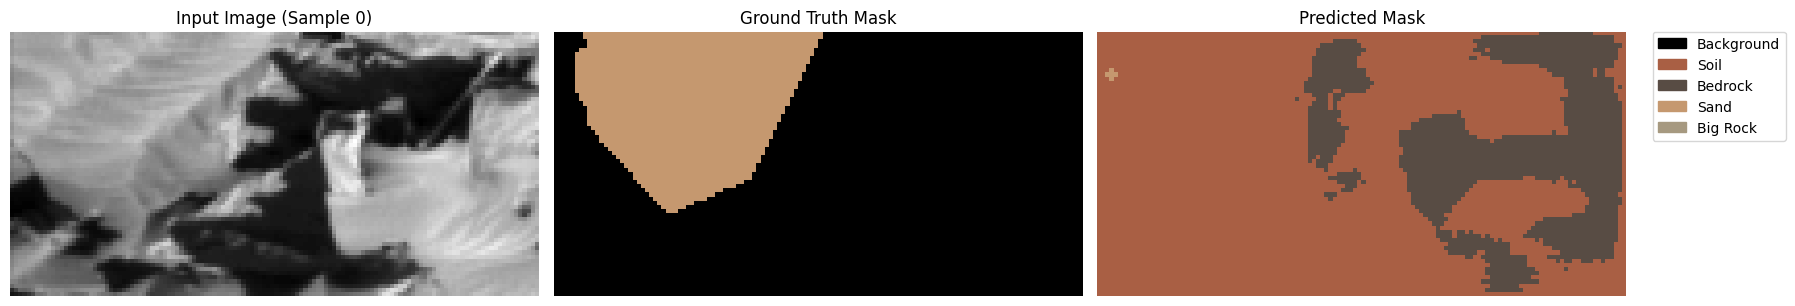

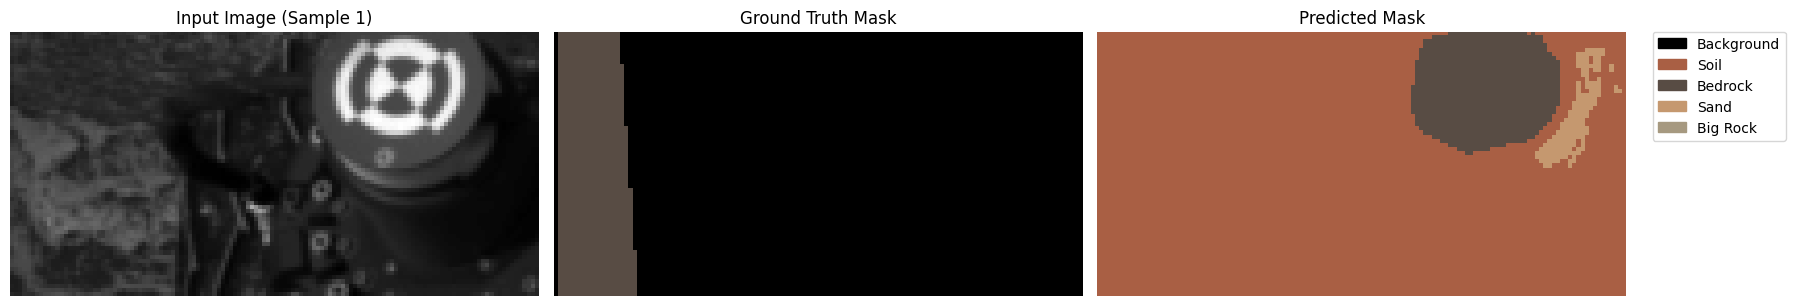


Epoch 1: val_mean_iou improved from -inf to 0.37991, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 90s 62ms/step - loss: 0.6885 - mean_iou: 0.2189 - sparse_categorical_accuracy: 0.3468 - val_loss: 0.3246 - val_mean_iou: 0.3799 - val_sparse_categorical_accuracy: 0.5112 - learning_rate: 1.0000e-04
Epoch 2/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2692 - mean_iou: 0.4402 - sparse_categorical_accuracy: 0.4732
Epoch 2: val_mean_iou improved from 0.37991 to 0.42149, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2690 - mean_iou: 0.4403 - sparse_categorical_accuracy: 0.4732 - val_loss: 0.1780 - val_mean_iou: 0.4215 - val_sparse_categorical_accuracy: 0.5557 - learning_rate: 1.0000e-04
Epoch 3/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1554 - mean_iou: 0.4675 - sparse_categorical_accuracy: 0.4915
Epoch 3: val_mean_iou did not improve from 0.42149
486/486 ━━━━━━━━━━━━━━━

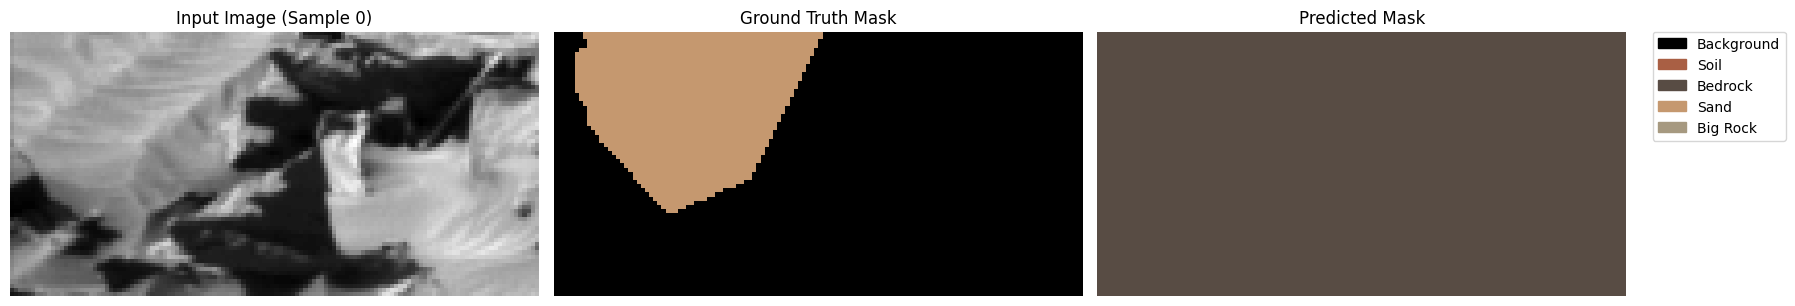

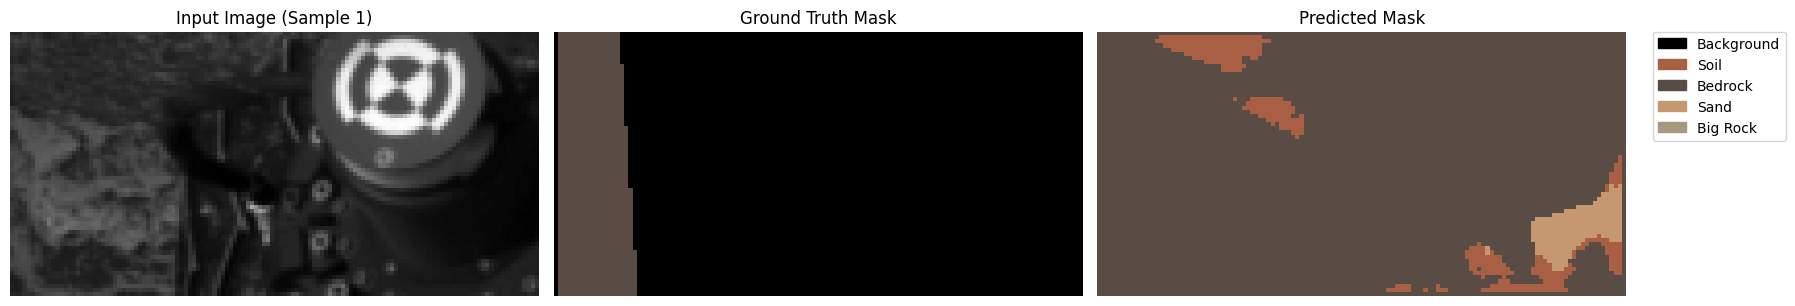


Epoch 6: val_mean_iou improved from 0.44028 to 0.51455, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0750 - mean_iou: 0.5075 - sparse_categorical_accuracy: 0.5175 - val_loss: 0.0712 - val_mean_iou: 0.5145 - val_sparse_categorical_accuracy: 0.6220 - learning_rate: 1.0000e-04
Epoch 7/1000
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0666 - mean_iou: 0.5314 - sparse_categorical_accuracy: 0.5321
Epoch 7: val_mean_iou did not improve from 0.51455
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0666 - mean_iou: 0.5315 - sparse_categorical_accuracy: 0.5322 - val_loss: 0.0700 - val_mean_iou: 0.4803 - val_sparse_categorical_accuracy: 0.5986 - learning_rate: 5.0000e-05
Epoch 8/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0627 - mean_iou: 0.5444 - sparse_categorical_accuracy: 0.5397
Epoch 8: val_mean_iou improved from 0.51455 to 0.51682, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━

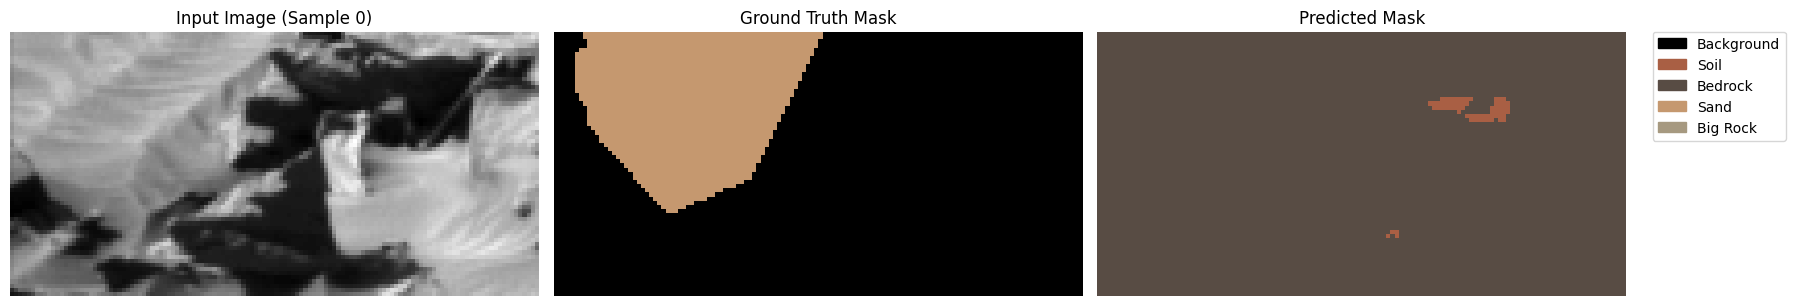

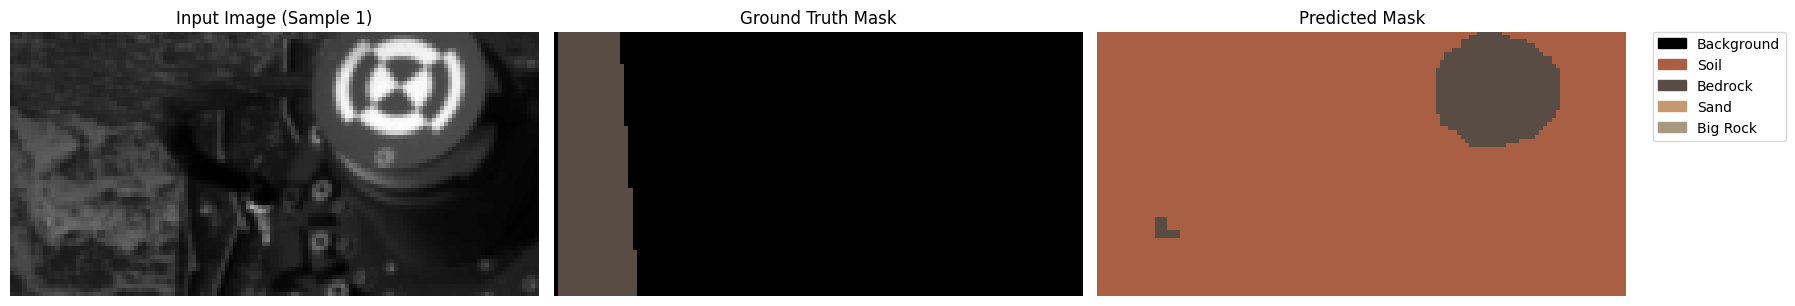


Epoch 11: val_mean_iou did not improve from 0.54540
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0548 - mean_iou: 0.5683 - sparse_categorical_accuracy: 0.5537 - val_loss: 0.0619 - val_mean_iou: 0.4651 - val_sparse_categorical_accuracy: 0.5875 - learning_rate: 5.0000e-05
Epoch 12/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0525 - mean_iou: 0.5866 - sparse_categorical_accuracy: 0.5635
Epoch 12: val_mean_iou improved from 0.54540 to 0.59307, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0525 - mean_iou: 0.5866 - sparse_categorical_accuracy: 0.5635 - val_loss: 0.0543 - val_mean_iou: 0.5931 - val_sparse_categorical_accuracy: 0.6744 - learning_rate: 2.5000e-05
Epoch 13/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0510 - mean_iou: 0.6020 - sparse_categorical_accuracy: 0.5724
Epoch 13: val_mean_iou did not improve from 0.59307
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0510 - mean_iou: 0.6021

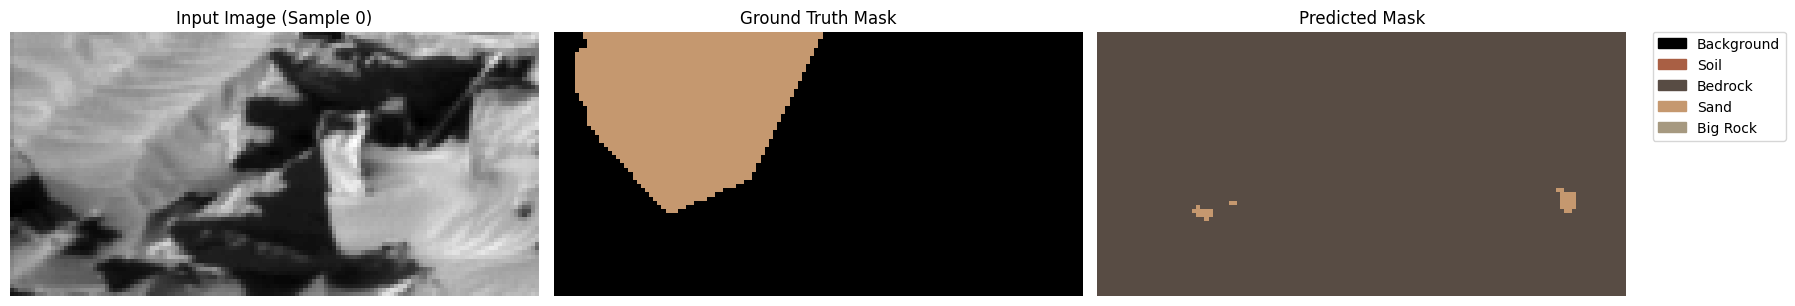

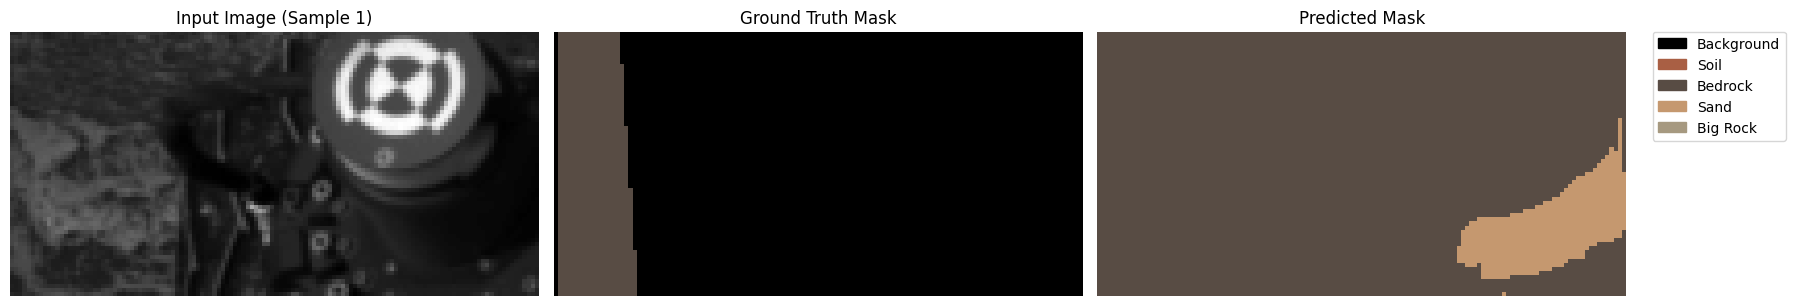


Epoch 16: val_mean_iou did not improve from 0.59604
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0475 - mean_iou: 0.6330 - sparse_categorical_accuracy: 0.5880 - val_loss: 0.0511 - val_mean_iou: 0.5954 - val_sparse_categorical_accuracy: 0.6751 - learning_rate: 2.5000e-05
Epoch 17/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0464 - mean_iou: 0.6461 - sparse_categorical_accuracy: 0.5943
Epoch 17: val_mean_iou did not improve from 0.59604
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0464 - mean_iou: 0.6461 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.0510 - val_mean_iou: 0.5883 - val_sparse_categorical_accuracy: 0.6710 - learning_rate: 1.2500e-05
Epoch 18/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0457 - mean_iou: 0.6557 - sparse_categorical_accuracy: 0.5990
Epoch 18: val_mean_iou improved from 0.59604 to 0.60443, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0457 - mean_iou: 0.6557

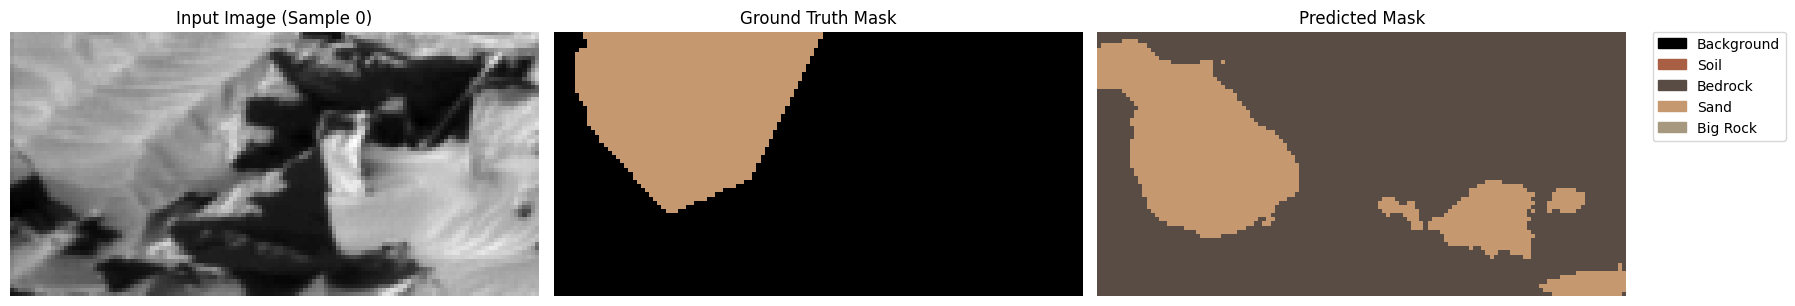

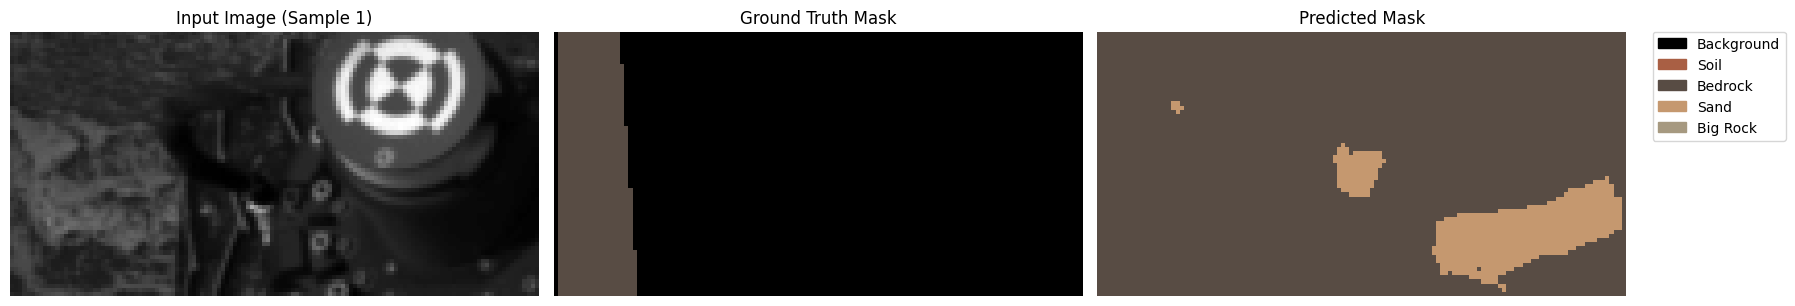


Epoch 21: val_mean_iou did not improve from 0.60503
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0440 - mean_iou: 0.6707 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.0488 - val_mean_iou: 0.6039 - val_sparse_categorical_accuracy: 0.6808 - learning_rate: 1.2500e-05
Epoch 22/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0436 - mean_iou: 0.6755 - sparse_categorical_accuracy: 0.6078
Epoch 22: val_mean_iou improved from 0.60503 to 0.61221, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0436 - mean_iou: 0.6755 - sparse_categorical_accuracy: 0.6078 - val_loss: 0.0482 - val_mean_iou: 0.6122 - val_sparse_categorical_accuracy: 0.6860 - learning_rate: 6.2500e-06
Epoch 23/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0432 - mean_iou: 0.6815 - sparse_categorical_accuracy: 0.6106
Epoch 23: val_mean_iou did not improve from 0.61221
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0432 - mean_iou: 0.6815

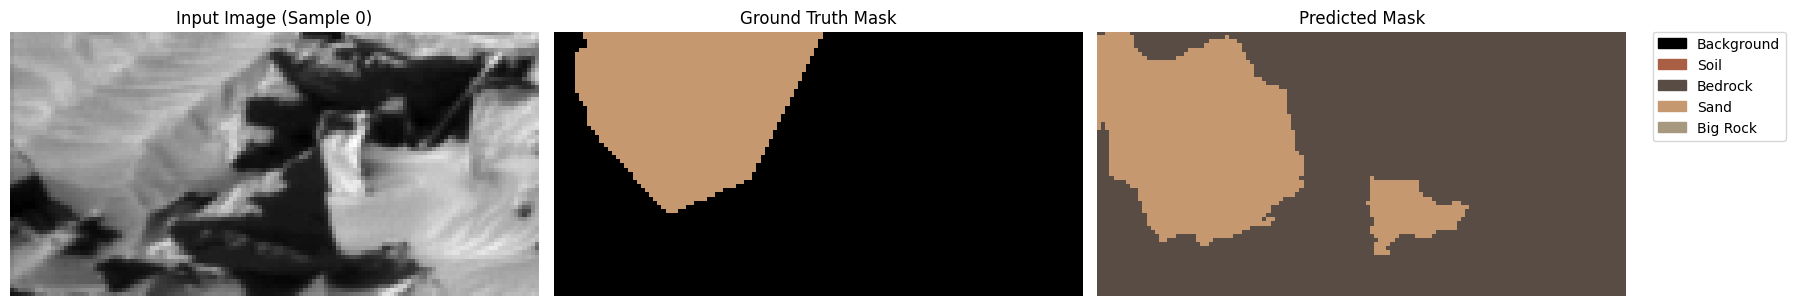

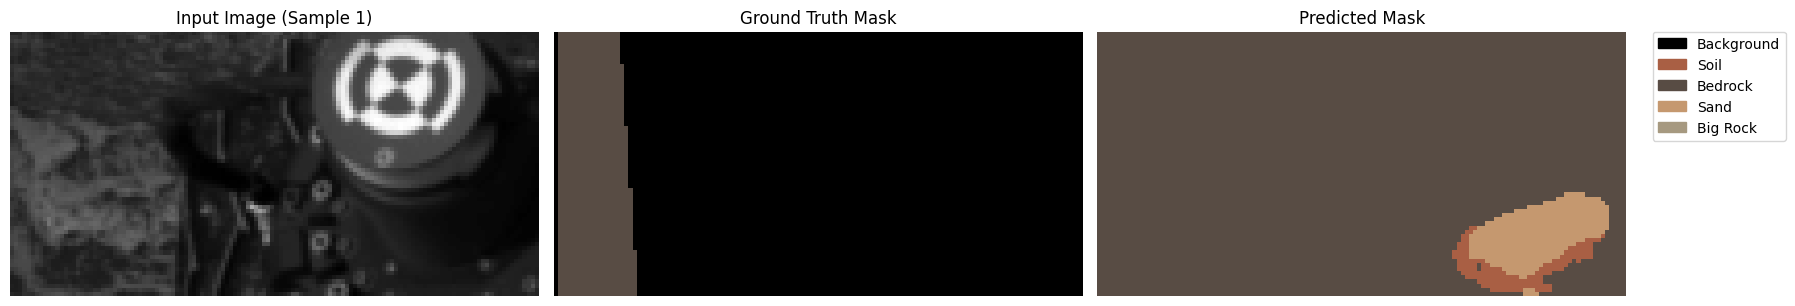


Epoch 26: val_mean_iou did not improve from 0.61339
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0422 - mean_iou: 0.6921 - sparse_categorical_accuracy: 0.6151 - val_loss: 0.0479 - val_mean_iou: 0.6034 - val_sparse_categorical_accuracy: 0.6805 - learning_rate: 6.2500e-06
Epoch 27/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0419 - mean_iou: 0.6955 - sparse_categorical_accuracy: 0.6165
Epoch 27: val_mean_iou improved from 0.61339 to 0.61713, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0419 - mean_iou: 0.6954 - sparse_categorical_accuracy: 0.6165 - val_loss: 0.0471 - val_mean_iou: 0.6171 - val_sparse_categorical_accuracy: 0.6893 - learning_rate: 3.1250e-06
Epoch 28/1000
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0417 - mean_iou: 0.6982 - sparse_categorical_accuracy: 0.6177
Epoch 28: val_mean_iou did not improve from 0.61713
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0417 - mean_iou: 0.698

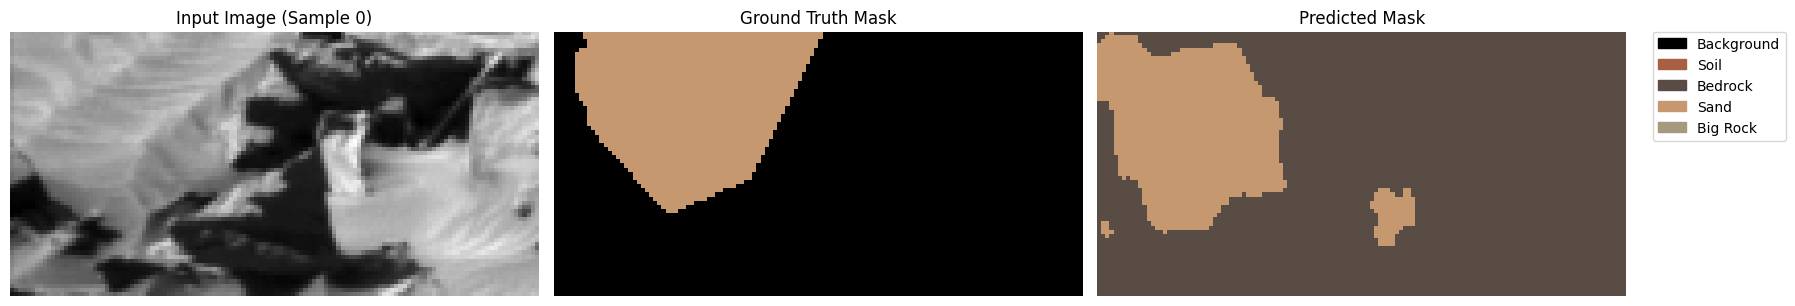

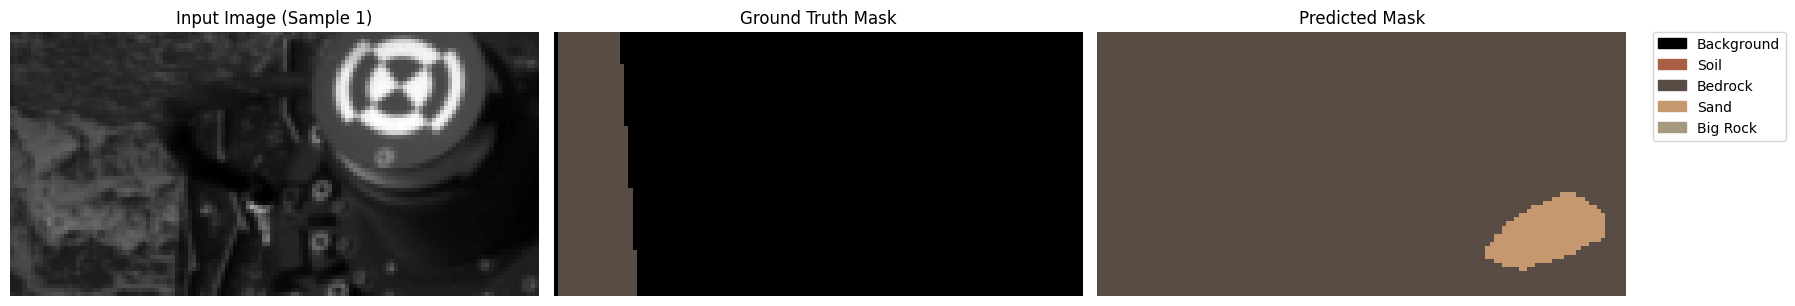


Epoch 31: val_mean_iou improved from 0.61713 to 0.61715, saving model to model_Final_Model_241214_163927.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0412 - mean_iou: 0.7043 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.0467 - val_mean_iou: 0.6171 - val_sparse_categorical_accuracy: 0.6889 - learning_rate: 3.1250e-06
Epoch 32/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0410 - mean_iou: 0.7057 - sparse_categorical_accuracy: 0.6208
Epoch 32: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0410 - mean_iou: 0.7056 - sparse_categorical_accuracy: 0.6208 - val_loss: 0.0466 - val_mean_iou: 0.6158 - val_sparse_categorical_accuracy: 0.6882 - learning_rate: 1.5625e-06
Epoch 33/1000
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0409 - mean_iou: 0.7072 - sparse_categorical_accuracy: 0.6215
Epoch 33: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0409 - mean_iou: 0.7072

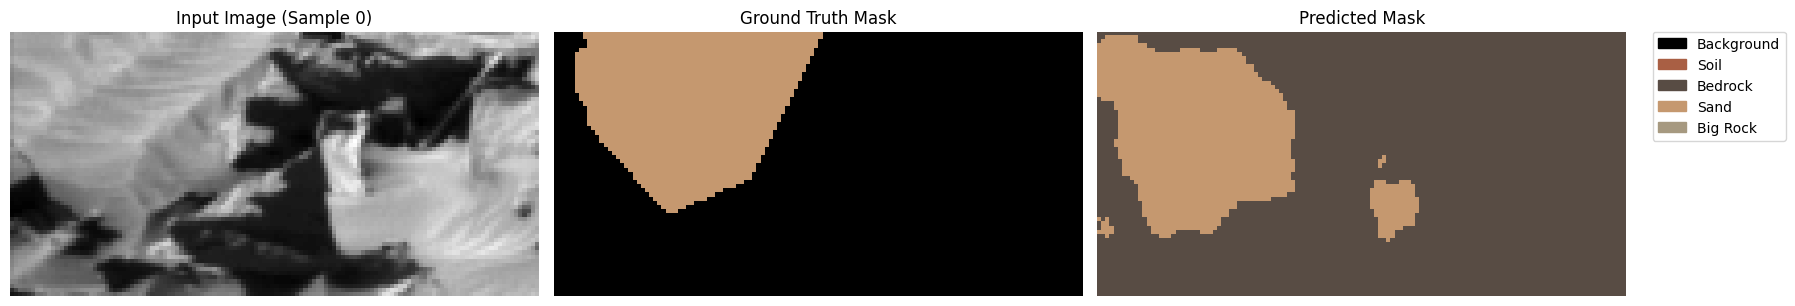

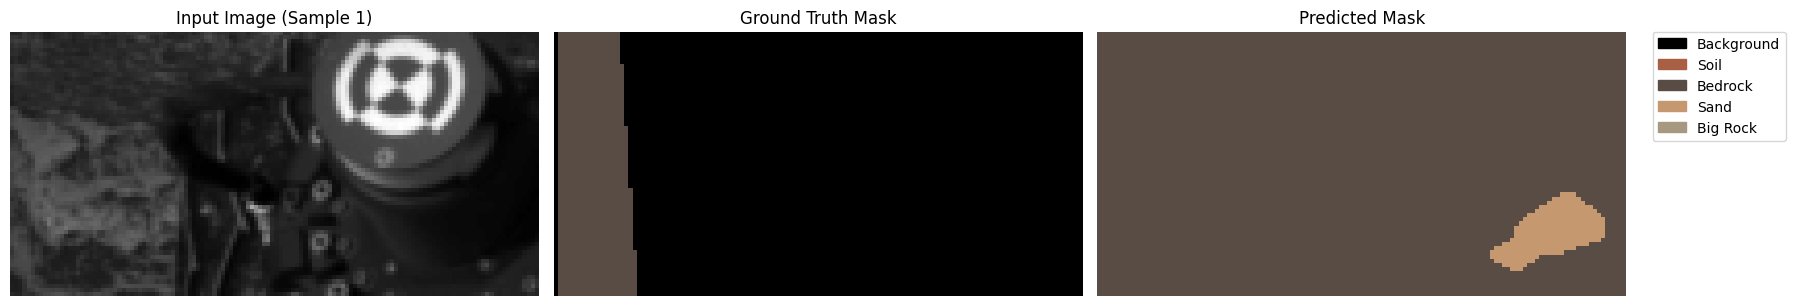


Epoch 36: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0406 - mean_iou: 0.7103 - sparse_categorical_accuracy: 0.6229 - val_loss: 0.0464 - val_mean_iou: 0.6150 - val_sparse_categorical_accuracy: 0.6877 - learning_rate: 1.5625e-06
Epoch 37/1000
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0405 - mean_iou: 0.7111 - sparse_categorical_accuracy: 0.6232
Epoch 37: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0405 - mean_iou: 0.7111 - sparse_categorical_accuracy: 0.6232 - val_loss: 0.0464 - val_mean_iou: 0.6131 - val_sparse_categorical_accuracy: 0.6862 - learning_rate: 1.0000e-06
Epoch 38/1000
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0404 - mean_iou: 0.7118 - sparse_categorical_accuracy: 0.6235
Epoch 38: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0404 - mean_iou: 0.7118 - sparse_categorical_accuracy: 0.6235 - val_loss: 0.0463 - 

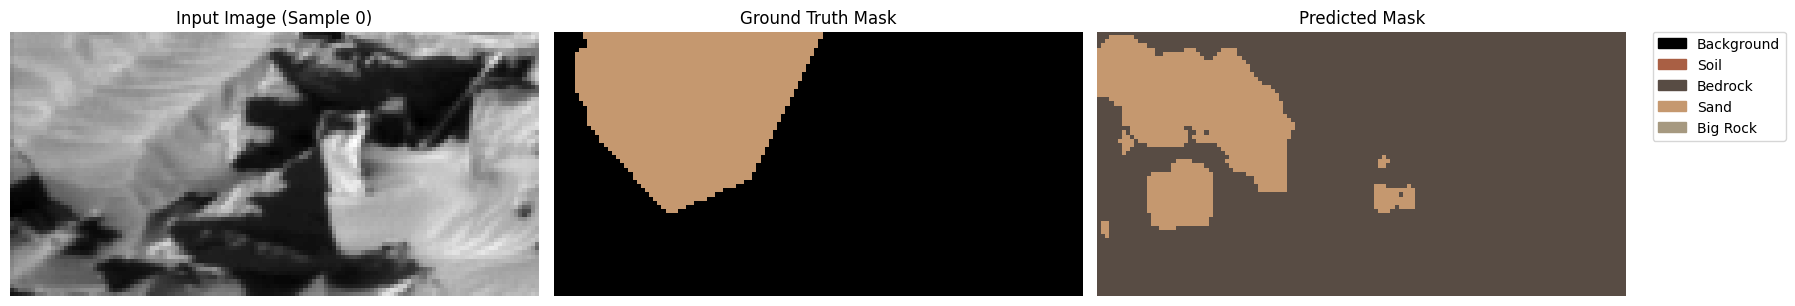

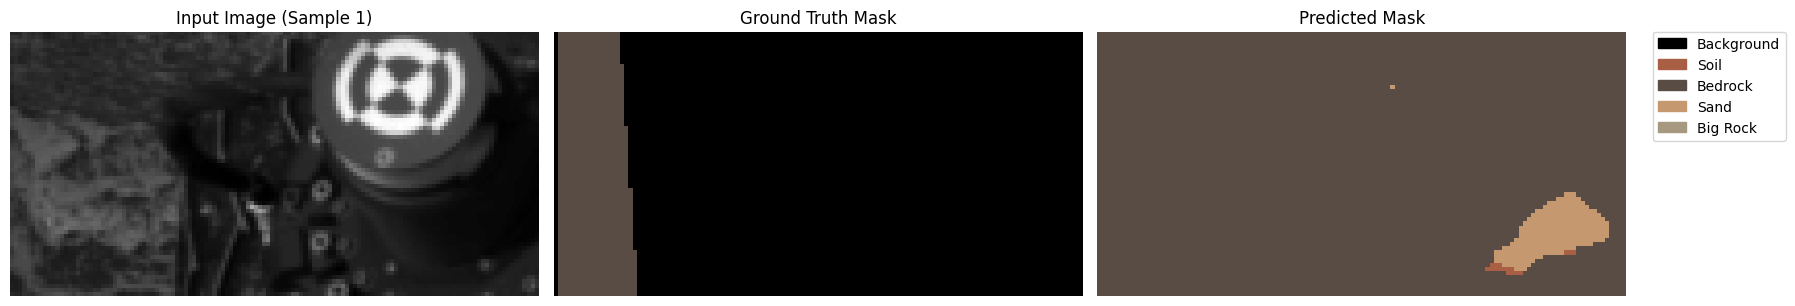


Epoch 41: val_mean_iou did not improve from 0.61715
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0401 - mean_iou: 0.7136 - sparse_categorical_accuracy: 0.6243 - val_loss: 0.0461 - val_mean_iou: 0.6142 - val_sparse_categorical_accuracy: 0.6871 - learning_rate: 1.0000e-06
Training completed after 31 epochs (Early Stopping).
Best Validation Mean IoU: 0.6171
Corresponding Validation Loss: 0.0467
Model saved to model_Final_Model_241214_163927.keras


In [41]:
batch_size = 16
epochs = 1000
seed = 42

viz_callback = VizCallback(X_val[:2], y_val[:2])  # Visualize first 2 validation images

# Choose which callbacks to activate
callbacks = [early_stopping, lr_scheduler, viz_callback, model_checkpoint]

history = model.fit(
    augmented_X_train, augmented_y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Retrieve best epoch and corresponding metrics from EarlyStopping based on Mean IoU
best_epoch = history.history['val_mean_iou'].index(max(history.history['val_mean_iou']))  # Index of the best validation mIoU
best_val_miou = max(history.history['val_mean_iou'])  # Best validation mIoU
best_val_loss = history.history['val_loss'][best_epoch]  # Best validation loss at that epoch

# Print the best metrics
print(f"Training completed after {best_epoch + 1} epochs (Early Stopping).")
print(f"Best Validation Mean IoU: {best_val_miou:.4f}")
print(f"Corresponding Validation Loss: {best_val_loss:.4f}")

# Save the final model after training
model.save(model_filename)
print(f"Model saved to {model_filename}")

## Predictions

In [42]:
# Load the most recent model
model = tfk.models.load_model(model_filename, compile = False)
print(f"Model loaded from {model_filename}")

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metric_main, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

# Predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

# Convert predictions to DataFrame
def y_to_df(y):
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Save predictions to CSV
submission_filename = f"sub_{model_name}_{timestamp}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# Download submission
if COLAB:
    from google.colab import files
    files.download(submission_filename)

print(f"Submission saved to {submission_filename}")

Model loaded from model_Final_Model_241214_163927.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step
Predictions shape: (10022, 64, 128)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission saved to sub_Final_Model_241214_163927.csv


### Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


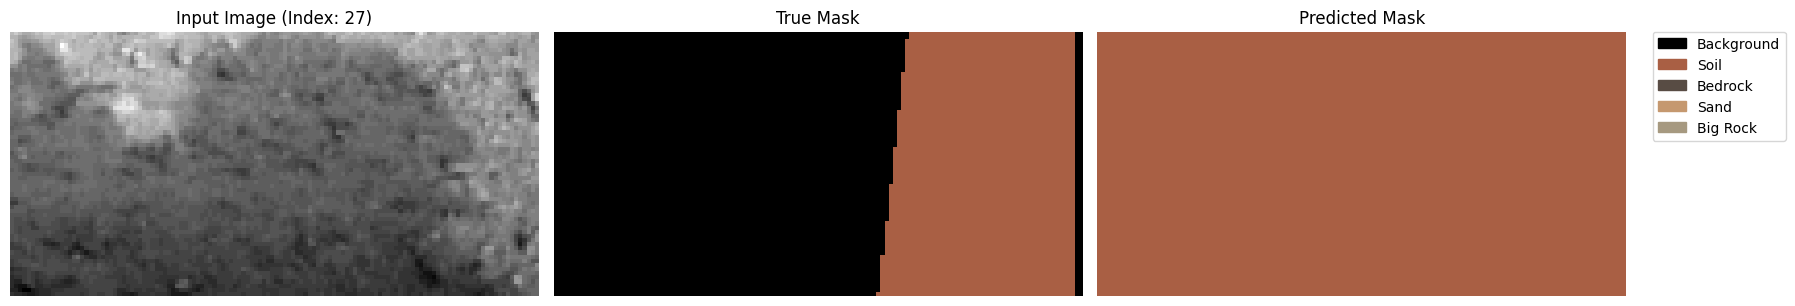

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


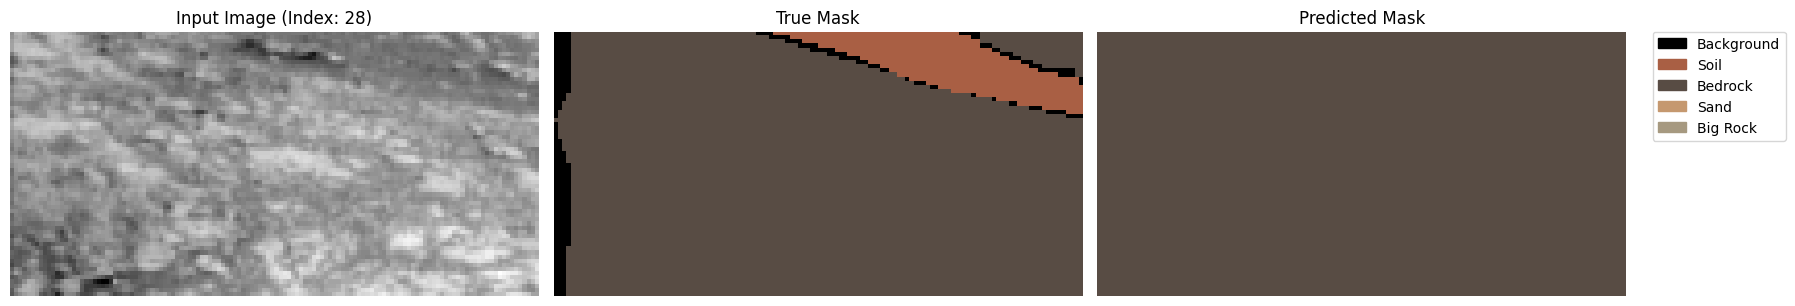

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


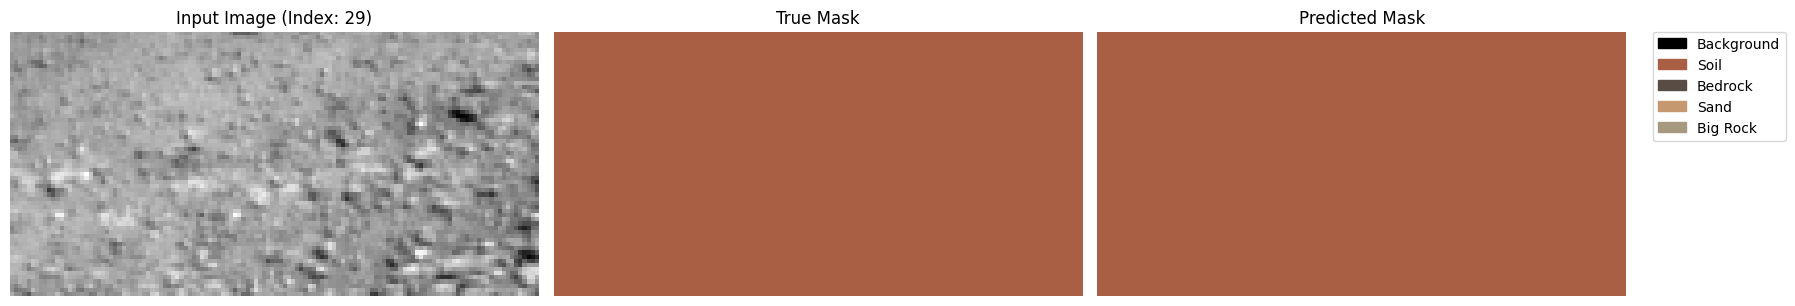

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


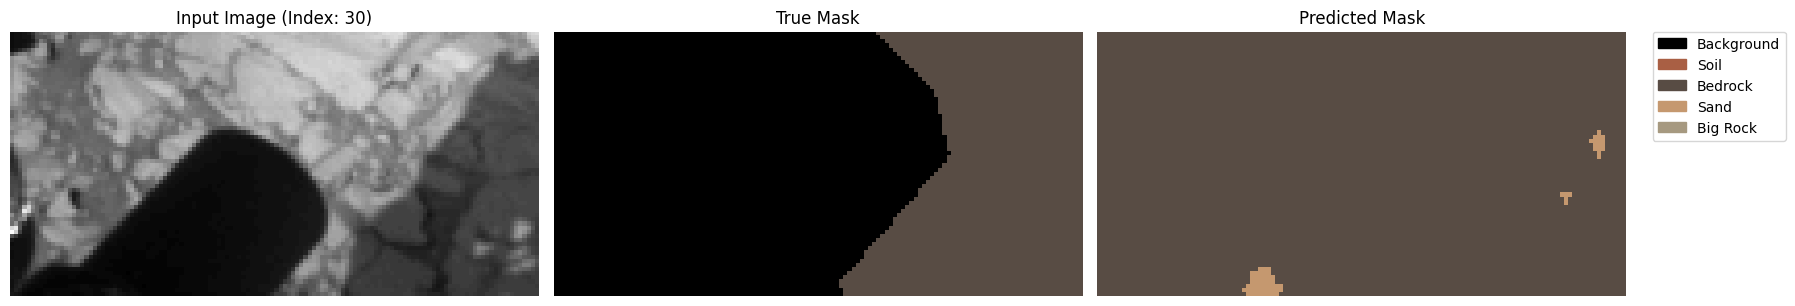

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


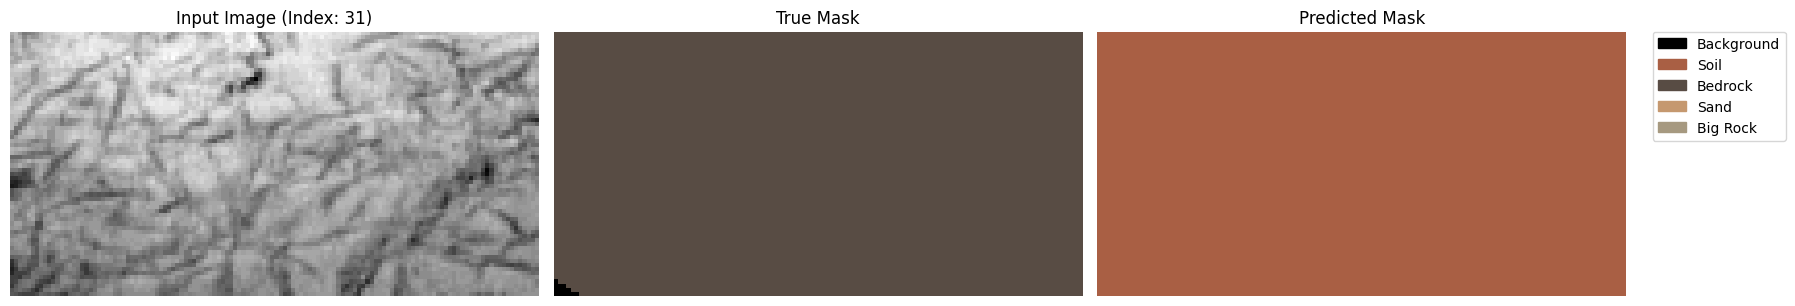

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


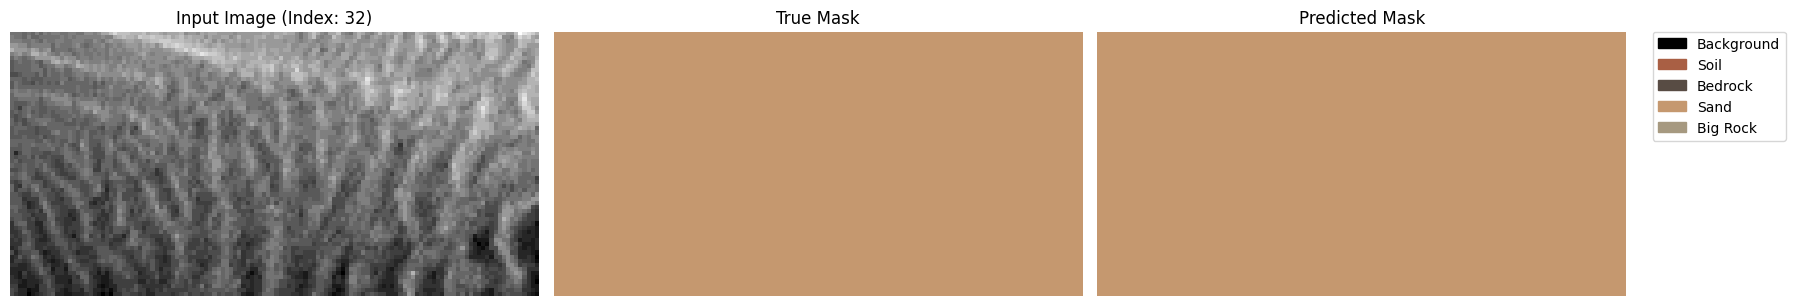

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


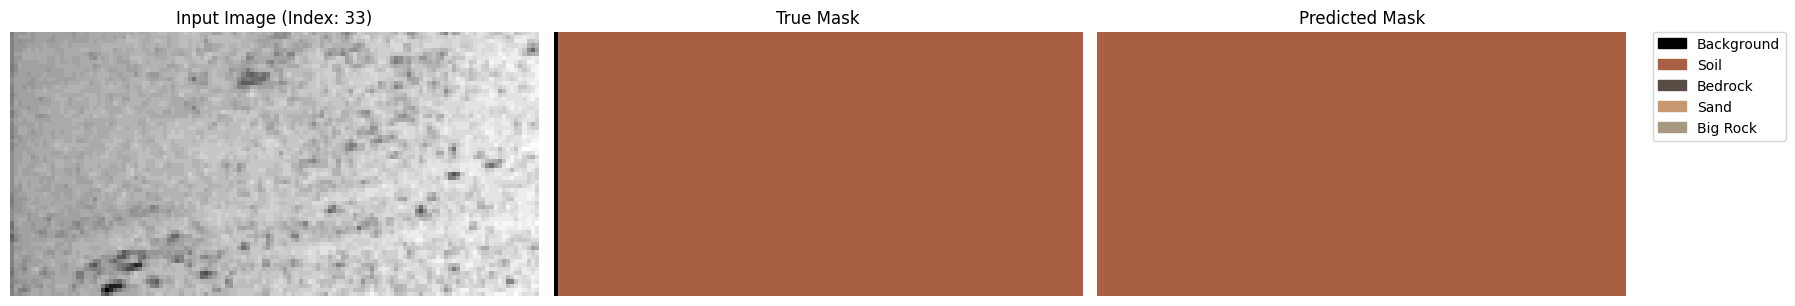

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


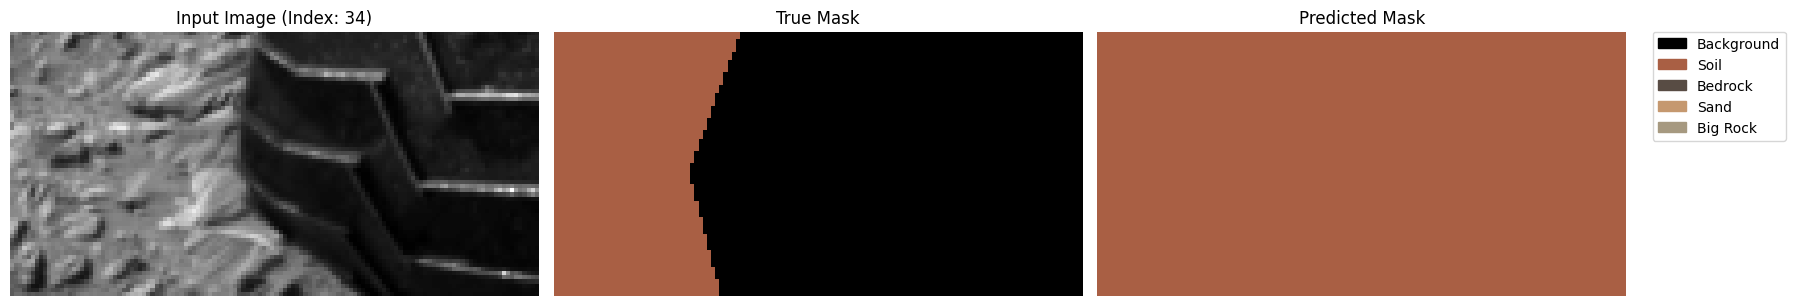

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


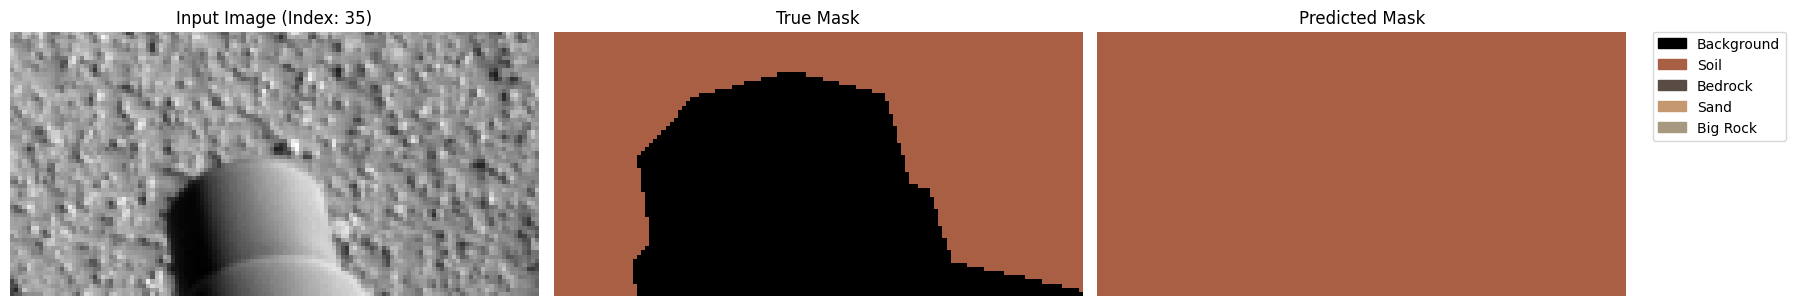

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


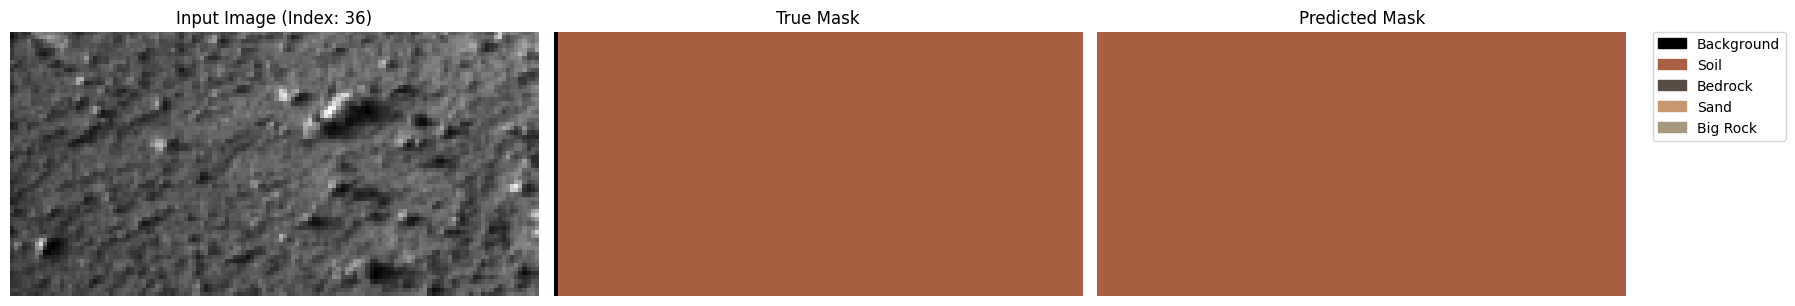

In [43]:
# Function to visualize predictions for a list of indices with a legend
def visualize_predictions(idx_list):
    # Ensure idx_list is a list even if a single integer is provided
    if isinstance(idx_list, int):
        idx_list = [idx_list]

    # Create legend patches
    patches = [mpatches.Patch(color=colors[i], label=label_mapping[i]) for i in label_mapping]

    for idx in idx_list:
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_mask = model.predict(img[np.newaxis, ...])[0]
        pred_mask = np.argmax(pred_mask, axis=-1)

        plt.figure(figsize=(18, 6))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.title(f'Input Image (Index: {idx})')
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)
        plt.axis('off')

        # True Mask
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(label_mapping)-1)
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(pred_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(label_mapping)-1)
        plt.axis('off')

        # Add Legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.tight_layout()
        plt.show()

# Example usage with a list of indices
visualize_predictions([i for i in range(27, 37)])  # Adjust the range as needed